In [1]:
import sqlite3
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
# only project_july26.db has up-to-date word feats
# UPDATE (aug 3): use project_july26_b.db, this fixed a database bug (too many user_id entries in word_features)
dbfile = 'project_july26_b.db' 
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?  
What sort of analyses or models do we want to run?

In [3]:
platform = 'tw' # ig = instagram, tw = twitter
condition = 'ptsd' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

#################
#
# INSTAGRAM ONLY 
# 
#################
additional_data = False # (instagram only) do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = False # (instagram only) include binary indicator of filter use? 

include_face_data = False # (instagram only) include has_face and face_ct? 

get_ratings_correlation = False # (instagram only) gets inter-rater correlation averages for each rated variable 

compare_ig_filters = False # (nstagram only) compares use of filters between target and control pops

#################
#
# TWITTER ONLY 
# 
#################
populate_wordfeats_db = False # (twitter only) generates word features from reagan code 

#################
#
# ALL PLATFORMS 
# 
#################
impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

post_event = True # limit pre-diag data to only posts after Event? (eg. ptsd trauma, pregnancy conception)

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

report_sample_size = True # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data

share_sm_disq_fnames = ["../../data/final/depressiontwitter_round1.csv",
                       "../../data/final/depressiontwitter_round2.csv",
                       "../../data/final/controltwitter.csv"]

path_head = '/'.join(['data-files',condition,platform])+'/'

load_from = 'pickle' # None, file, pickle :: loads masters from pickled file, or just masters from csv

write_to = None # None, file, pickle  :: writes initial data (prepare_raw_data()) to csv or pickle

final_pickle = True # pickles entire data dict after all masters are created

make_hourly_plot = False # make plot of aggregated hourly posting for target vs control?

run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : False, 
    'density' : False, 
    'ml' : True, 
    'nhst' : True, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': False, # (random forest) do we have enough variables to require a taller plot window?
    'acc_avg': 'binary', # (ml) accuracy score basis for f1, precision, etc. "binary" or "weighted"
    'use_ttest':False, # (nhst) compute t-tests for each variable?
    'best_pca':10, # (pca) how many components to use?
    'show_pca_comp_plot':True, # (pca) show scree plot?
    'rf_imp_cutoff':.015, # (random forest) show feats with importance >= X
    'rf_imp_subset':10, # (random forest) show top X important feats
    'rf_n_est':1200, # (random forest) how many trees? suggest 10 for demo, 100 for good, 1200 for max out
    'stratify':True # (ml) stratify train_test splits based on class balance in y?
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

### hourly_plot sets local timestamp for every post 
The timezone acquisition happens in get_timezones.py.  That's not currently imported here, but it should get merged eventually.  to_localtime_wrapper() assumes that the 'tz' field in meta_tw is populated as best as can be done.
Remember not all Twitter accounts have time zone info, and Instagram has none at all, aside from occassional lat/lon data (which we didn't bother to try and convert).  
  
### WARNING: hourly_plot() is not well-constructed, and rewrites meta_tw, leaving some odd results!
In particular, None gets replaced with '' for some reason, and this screws up other things.  Be careful.

In [5]:
if make_hourly_plot:
    hourly_plot(conn)

In [28]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

SAMPLE SIZES: target populations

TARGET :: PTSD / TWITTER total: 73
TARGET :: PTSD / TWITTER tsq > 5: 69


SAMPLE SIZES: control populations

CONTROL :: PTSD / TWITTER total: 116



In [7]:
if report_sm_disq:
    total_attempted = 0
    total_disq = 0
    
    for fname in share_sm_disq_fnames:
        attempt, disq = report_share_sm_disq(fname)
        total_attempted += attempt
        total_disq += disq
        print

    print
    print 'total attempted survey respondents (including target + control):', total_attempted
    print 'total disqualified for refusing to share social media:', total_disq
    print 'percentage disqualified:', total_disq / float(total_attempted)

Total attempted: 927
Disqualified for share_sm: 393
% disq for share_sm: 0.423948220065

Total attempted: 428
Disqualified for share_sm: 98
% disq for share_sm: 0.228971962617

Total attempted: 906
Disqualified for share_sm: 299
% disq for share_sm: 0.330022075055


total attempted survey respondents (including target + control): 2261
total disqualified for refusing to share social media: 790
percentage disqualified: 0.349402919062


## Load ready data, or prepare raw data

Set load_from to determine action here.  

In case you don't have a pickled data dict or saved csv, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle/csv

In [5]:
if not load_from: # construct data dict from raw data
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, post_event=post_event, posting_cutoff=posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
else: # load data dict from saved file
    data = pickle.load(open("{path}{cond}_{pl}_data.p".format(path=path_head,
                                                              cond=condition,
                                                              pl=platform), "rb" ) )

### This next section generates word features from Andy Reagan's code

Only set populate_wordfeats_db = True if you need to redo the features for some reason!
    

In [6]:
if populate_wordfeats_db:
    pops_to_populate = ['target', 'control']
    create_word_feats_wrapper(pops_to_populate, gb_types, data, condition, conn, 
                              write_to_db=True, testing=False)                        

## Descriptive stats 

Total posts across all groups: 243775
Mean posts per participant: 1401.01 (SD=1283.88)
Median posts per participant: 946.5

POPULATION: TARGET
Total participants analyzed: 63
Total posts: 91589
Mean posts per participant: 1453.79 (SD=1320.7)
Median posts per participant: 1058.0
Earliest date of first diagnosis: 2010-04-11 00:00:00
Latest date of first diagnosis: 2015-12-29 00:00:00
Proportion diagnosed between 2013-2015 (target only): 0.94
Average age: 30.65 (SD=7.57)
Min age: 21
Max age: 54


POPULATION: CONTROL
Total participants analyzed: 111
Total posts: 152186
Mean posts per participant: 1371.05 (SD=1267.59)
Median posts per participant: 893.0
Proportion female (control only): 0.51
Average age: 33.25 (SD=10.22)
Min age: 19
Max age: 63




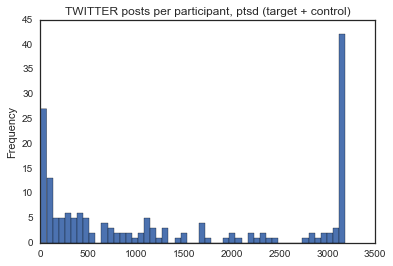

In [20]:
output = get_descriptives(data, condition, platform_long, additional_data, conn, return_output=True)

## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST

In [12]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in ['created_date']: # don't put user_id without created_date and weekly!

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff, 
                       use_pca=False, scale_data=False)


Merge to master: MAIN created_date
master created_date shape: (70191, 52)

Building ML models...

Stratify split: True


KeyboardInterrupt: 

In [14]:
gb_type = 'created_date'
print 'total observations in {} data:'.format(gb_type), data['master'][gb_type].shape[0]
print 'target observations in {} data:'.format(gb_type), data['master'][gb_type].target.sum()

total observations in created_date data: 54197
target observations in created_date data: 13008


## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

In [22]:
def importance_wrapper(fits, ctype, model_feats, title, condition, tall_plot=False, imp_cutoff=.01, imp_subset=10):

    # replace "happs" with "happy" (eg. LabMT_happs -> LabMT_happy)
    model_feats = [re.sub('happs','happy',x) for x in model_feats]

    # Plot the feature importances of the forest
    fimpdf = pd.DataFrame(fits[ctype]['clf'].feature_importances_, index=model_feats, columns=['importance'])
    
    if tall_plot:
        fsize = (5,11)
    else:
        fsize = (3,4)
    plt.figure() 
    fimpdf = fimpdf.sort_values('importance', ascending=False).ix[fimpdf.importance > imp_cutoff,:]
    
    feat_names = fimpdf.index
    fimpdf.reset_index(drop=True)
    ax = fimpdf.ix[0:imp_subset,'importance'].plot(kind='barh', figsize=fsize, fontsize=14)
    plt.gca().invert_yaxis()
    major_formatter = FuncFormatter(drop_leading_zero_formatter)
    ax.xaxis.set_major_formatter(major_formatter)
    plt.xticks(fontsize=10)
    plt.title("Top {} predictors ({})".format(condition.upper(),title), fontsize=16)
    plt.show()

In [17]:
def make_models(d, condition, clf_types=['lr','rf','svc'], 
                excluded_set=None, use_pca=False, stratify_split=False,
                labels={'known_0':'known_control',
                        'known_1':'known_target',
                        'pred_0':'pred_control',
                        'pred_1':'pred_target'}):

    ''' Makes, fits, and reports on machine learning models.  The ML workhorse in this script.
        NOTE: clf_types can include: 'lr' (logistic reg.),'rf' (random forests),'svc' (support vec.) 
        NOTE: set stratify_split = True to create stratified train/test splits '''

    mdata = d['data']
    title = d['name']
    unit = d['unit']
    target = d['target'] 
    feats = d['features']
    
    X = mdata[feats].copy()
    y = mdata[target]

    print 'Stratify split:', stratify_split
    if stratify_split:
        stratify = y
    else:
        stratify = None 

    cleanX(X)

    model_feats = X.columns

    imp = Imputer(strategy='median')
    X = imp.fit_transform(X,y)
    
    if use_pca:
        # stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
        # nxn.se/post/36838219245/loadings-with-scikit-learn-pca
        # stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ration-in-pca-with-sklearn
        
        pca = PCA(n_components='mle')
        X_reduced, num_pca_comp = pca_explore(pca, X, unit, d['best_pca_num_comp'], d['show_pca_comp_plot'])
        
        # IMPORTANT! Only need to run pca_model2 once to determine best num_pca_comp. Takes awhile to run (~20 min for tw).
        if d['best_pca_num_comp'] is None:
            num_pca_comp = pca_model(pca, X_reduced, y, num_pca_comp)
        else:
            num_pca_comp = d['best_pca_num_comp'] # passed in from notebook
            
        pca_report(pca, model_feats)

        # we do all subsequent modeling with the best PCA component vectors
        if num_pca_comp + 1 > X_reduced.shape[1]:
            max_ix = X_reduced.shape[1] 
        else:
            max_ix = num_pca_comp+1

        X = X_reduced[:,0:max_ix].copy() 
        model_feats = pd.Series(['pca_{}'.format(x) for x in np.arange(max_ix)])

        pca_df = pd.DataFrame(X, columns=model_feats)
        pca_df['target'] = y.values

    else:
        pca_df = None
    
    fits = {}
    initialize_model_fits(fits, d['kernel'], d['rf_params'])
    
    master_results = []
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    ct = 0
    best_f1 = 0
    
    cv_len = 1
    
    master_results = {}
    cv_iters = {'tn':[], 'fn':[], 'pneg':[], 'neg':[], 'precision':[], 'specificity':[], 'recall':[], 'npv':[], 'f1':[] }
   
    for ctype in clf_types:
        for i in range(cv_len):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=d['test_size'], stratify=stratify)

            fit = fits[ctype]['clf'].fit(X_train, y_train)

            probas_ = update_acc_metrics(fit, X_test, y_test, cv_iters, d['acc_avg'])
            plot_roc(y_test, probas_, mean_tpr, mean_fpr, condition, i=i)

        # compute mean accuracy metrics over cv iterations, print results
        for metric in ['tn','pneg','neg','npv','specificity','precision','recall','f1']:
            master_results[metric] = (round(np.mean(cv_iters[metric]),4), round(np.std(cv_iters[metric]),4))  
            print metric.upper(), '::', master_results[metric]
        
        plot_roc(y_test, probas_, mean_tpr, mean_fpr, condition)

        if use_pca:
            print 
            print 'NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!'
            print
        
        print 'UNIT OF OBSERVATION:', unit.upper()

        total_obs = X_test.shape[0]
        total_neg = np.sum(y_test==0)
        prop_neg = round((total_neg)/float(total_obs),3)

        output = {}
        output['X_test'] = X_test
        output['y_test'] = y_test

        output[ctype] = fits[ctype]['clf']

        if ctype == 'rf':
            importance_wrapper(fits, ctype, model_feats, title, condition,
                               d['tall_plot'], d['rf_params']['imp_cutoff'], d['rf_params']['imp_subset'])
    
        output[ctype] = fits[ctype]['clf']

        actualpos = np.sum(output['y_test'])
        prevalence = actualpos / float(output['y_test'].shape[0])

        print 'actualpos:', actualpos
        print 'total y_test:', output['y_test'].shape[0]
        print 'prevalence:', prevalence 
        print 
        #print_model_summary(fits[ctype], ctype, target, title, X_test, y_test, labels, average=acc_avg)

        out_of_100(prevalence, master_results['precision'][0], master_results['specificity'][0], master_results['recall'][0])
    
    return output, pca_df, best_f1, master_results

In [15]:
def master_actions(master, target, control, condition, m, params, gb_type, 
                   report, aparams, clfs, additional_data, posting_cutoff,
                   use_pca=False, scale_data=False):
    ''' Performs range of actions on master data frame, including plotting, modeling, and saving to disk. 
        
        Note: "Master" may refer to any set of target+control data, including timeline subsets. 
        In other words, both the full dataset and subsets of full dataset may be passed as "master" argument.'''

    if aparams['create_master']:

        # merge target, control, into master
        print 
        print 'Merge to master: {} {}'.format(report, gb_type)
        merge_to_master(master, target, control, m, params['vars'], gb_type, additional_data)

        print 'master {} shape:'.format(gb_type), master[gb_type].shape
        print

        master['model'][gb_type] = {}
    
    if aparams['density']:
        compare_density(master, m, gb_type, params['vars'], additional_data)

    if aparams['corr']:
        corr_plot(master, m, gb_type, params['vars'], additional_data, aparams['print_corrmat'])

    if aparams['ml']:
        print 'Building ML models...'
        print 
        if additional_data:
            vlist = 'means'
        else:
            vlist = 'no_addtl_means'

        if aparams['rf_imp_cutoff']:
            imp_cutoff = aparams['rf_imp_cutoff']
        else:
            imp_cutoff = .015 # use .01 for instagram, .015 for twitter (depression)

        gb_type_report = 'daily bins' if gb_type == 'created_date' else '{} bins'.format(gb_type)
        
        model_df = {'name':'{}'.format(gb_type_report),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][m][gb_type][vlist],
                    'target':'target',
                    'platform':m,
                    'test_size':.3, # test split for train/test
                    'acc_avg':'binary',
                    'best_pca_num_comp':aparams['best_pca'], # opt: 69 for tw-MAIN-created_date, but 2 works also!
                    'show_pca_comp_plot':aparams['show_pca_comp_plot'],
                    'kernel':'rbf', # for SVC, not used anymore
                    'tall_plot':aparams['tall_plot'],
                    'acc_avg':aparams['acc_avg'],
                    'rf_params': {# params optimized with 5-fold CV, see optimize_rf_hyperparams()
                                  'class_wt':'balanced',
                                  'max_feat':'sqrt',
                                  'n_est':aparams['rf_n_est'],
                                  'min_ss':2,
                                  'min_sl':1,
                                  'max_depth':None,
                                  'imp_cutoff':aparams['rf_imp_cutoff'],
                                  'imp_subset':aparams['rf_imp_subset']} 
                   }

        output, pca_df, best_f1, master_results = make_models(model_df, condition=condition, clf_types=clfs, 
                                                           excluded_set=params['model_vars_excluded'][m][gb_type],
                                                           use_pca=use_pca, stratify_split=aparams['stratify'])

        for k in output.keys():
            master['model'][gb_type][k] = output[k]

    if aparams['save_to_file']:
        if use_pca:
            save_df = pca_df.copy()
            pca_ct = action_params['best_pca']+1
        else:
            save_df = master[gb_type].copy()
            pca_ct = None
            
        save_master_to_file(additional_data, posting_cutoff, use_pca, pca_ct, 
                            gb_type, report, condition, m, save_df)

    if aparams['nhst']:

        if additional_data:
            vlist = 'means'
        else:
            vlist = 'no_addtl_means'

        print
        print 'LOGISTIC REGRESSION'
        
        _, master['model']['logodds'] = logreg_wrapper(master, gb_type, vlist, params['vars'][m],
                                                       additional_data, scale_data=scale_data)

        if aparams['use_ttest']:
            print
            print 'TTEST'
            ttest_out = ttest_wrapper(master, gb_type, params['vars'][m], additional_data)
            master['model'][gb_type]['ttest'] = ttest_out[0]
            master['model'][gb_type]['ttest_pvals'] = ttest_out[1]

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE (PCA:False)

Merge to master: before-from_diag created_date
master created_date shape: (46639, 52)

Building ML models...

Stratify split: True
TN :: (12208.0, 0.0)
PNEG :: (12733.0, 0.0)
NEG :: (12357.0, 0.0)
NPV :: (0.959, 0.0)
SPECIFICITY :: (0.988, 0.0)
PRECISION :: (0.882, 0.0)
RECALL :: (0.679, 0.0)
F1 :: (0.767, 0.0)


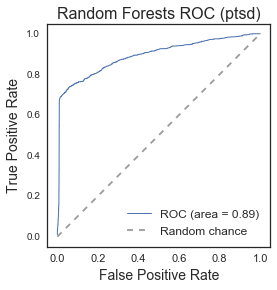

UNIT OF OBSERVATION: CREATED_DATE


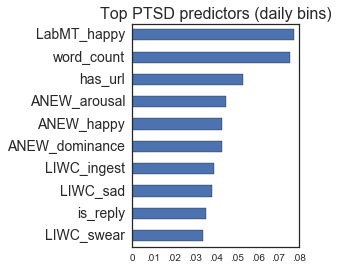

actualpos: 1635
total y_test: 13992
prevalence: 0.116852487136

Out of 100 random observations...

n1 12.0
n0 88.0
9.0 positive IDs
1.0 false alarms
3.0 false negatives
87.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.341363
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                46639
Model:                          Logit   Df Residuals:                    46598
Method:                           MLE   Df Model:                           40
Date:                Sat, 13 Aug 2016   Pseudo R-squ.:                 0.05338
Time:                        17:11:03   Log-Likelihood:                -15921.
converged:                       True   LL-Null:                       -16819.
                                        LLR p-value:                     0

In [23]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    for period in ['before']:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in ['from_diag']:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}-{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in ['created_date']:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {} (PCA:{})'.format(period.upper(), turn_point.upper(), gb_type.upper(), use_pca)
                # merge target, control, into master
                master_actions(master, target, control, condition, platform, 
                               params, gb_type, report, action_params, clfs, additional_data, posting_cutoff,
                               use_pca, scale_data=True)

In [21]:
for compare in ['LIWC','ANEW']:
    comp_var = "{}_happs".format(compare)
    print 'correlation between LabMT and {}:'.format(comp_var), data['master']['before']['from_diag']['created_date'][['LabMT_happs',comp_var]].corr()
    print

 correlation between LabMT and LIWC_happs:              LabMT_happs  LIWC_happs
LabMT_happs     1.000000    0.371675
LIWC_happs      0.371675    1.000000

correlation between LabMT and ANEW_happs:              LabMT_happs  ANEW_happs
LabMT_happs     1.000000    0.359325
ANEW_happs      0.359325    1.000000



In [27]:
tdelta = (pd.to_datetime(data['target']['tweets'].diag_date)-pd.to_datetime(data['target']['tweets'].event_date))
days_delta = tdelta.dt.days.median()
print 'Median days between trauma event and diagnosis (PTSD):', days_delta
print 
print 'Descriptives:'
tdelta.dropna().dt.days.describe()

Median days between trauma event and diagnosis (PTSD): 338.0


count    70549.000000
mean       586.112617
std        642.110091
min         -1.000000
25%         84.000000
50%        338.000000
75%       1035.000000
max       1984.000000
dtype: float64

In [16]:
gb_type = 'created_date'
print 'total observations in before_diag {}:'.format(gb_type), data['master']['before']['from_diag'][gb_type].shape[0]
print 'target observations in before_diag {}:'.format(gb_type), data['master']['before']['from_diag'][gb_type].target.sum()

total observations in before_diag created_date: 46926
target observations in before_diag created_date: 5737


### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [31]:
if final_pickle:
    pickle.dump( data, open( "{path}{cond}_{pl}_data.p".format(path=path_head,cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [11]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow
if run_before_after:
    for gb_type in ['created_date','weekly']: 
        before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: created_date

Total vars: 40
Num components selected by Minka MLE: 39
Cumulative % variance explained per component:
[ 50.01  57.6   61.54  64.66  67.49  69.98  72.09  74.07  75.93  77.75
  79.36  80.87  82.31  83.64  84.95  86.18  87.38  88.46  89.5   90.52
  91.53  92.41  93.23  94.01  94.78  95.51  96.22  96.85  97.43  97.95
  98.46  98.92  99.24  99.43  99.6   99.74  99.83  99.9   99.95]


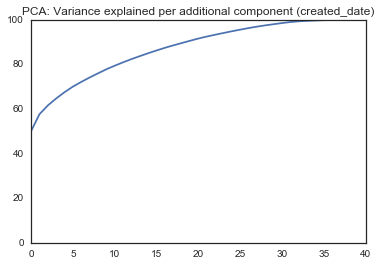

LIWC_article    0.216178
LIWC_sad        0.215952
LIWC_posemo     0.212858
LIWC_ingest     0.211852
LIWC_swear      0.211536
LIWC_verb       0.208710
LIWC_anx        0.197824
LIWC_work       0.197488
LIWC_cogmech    0.194048
LIWC_body       0.193928
Name: PCA_0, dtype: float64

ANEW_happs        0.503299
ANEW_dominance    0.498044
ANEW_arousal      0.478296
LabMT_happs       0.306164
LIWC_happs        0.229755
word_count        0.199738
LIWC_ipron        0.140664
tweet_count       0.084464
LIWC_social       0.069787
LIWC_relig        0.066465
Name: PCA_1, dtype: float64

is_rt             0.662878
is_reply          0.620900
word_count        0.314659
LIWC_i            0.132893
LIWC_assent       0.086892
ANEW_happs        0.085883
LIWC_death        0.084846
ANEW_dominance    0.079089
LIWC_ipron        0.078258
LIWC_we           0.069174
Name: PCA_2, dtype: float64

TN :: (11893.0, 0.0)
PNEG :: (15197.0, 0.0)
NEG :: (12441.0, 0.0)
NPV :: (0.783, 0.0)
SPECIFICITY :: (0.956, 0.0)
PRECISION

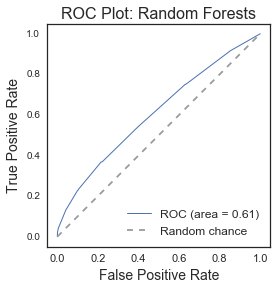


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE


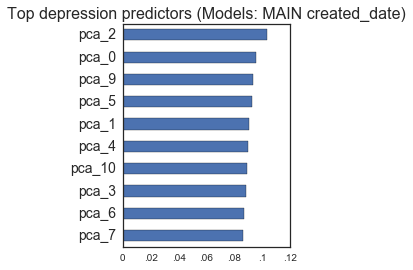

actualpos: 3819
total y_test: 16260
prevalence: 0.234870848708

Out of 100 random observations...

n1 24.0
n0 76.0
4.0 positive IDs
3.0 false alarms
20.0 false negatives
73.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.535754
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                54197
Model:                          Logit   Df Residuals:                    54185
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Aug 2016   Pseudo R-squ.:                 0.02784
Time:                        09:47:54   Log-Likelihood:                -29036.
converged:                       True   LL-Null:                       -29868.
                                        LLR p-value:                     

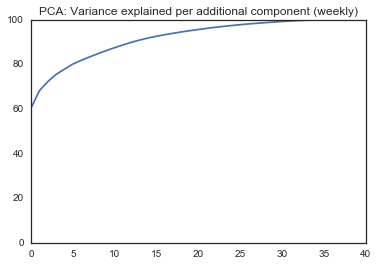

LIWC_sad        0.200240
LIWC_article    0.200217
LIWC_posemo     0.198954
LIWC_ingest     0.198915
LIWC_swear      0.198512
LIWC_verb       0.195599
LIWC_anx        0.192875
LIWC_work       0.192738
LIWC_body       0.191816
LIWC_cogmech    0.191209
Name: PCA_0, dtype: float64

ANEW_happs        0.513849
ANEW_dominance    0.509365
ANEW_arousal      0.488461
LabMT_happs       0.296324
LIWC_happs        0.231959
LIWC_ipron        0.178256
word_count        0.171495
tweet_count       0.065421
LIWC_relig        0.051706
LIWC_social       0.050611
Name: PCA_1, dtype: float64

is_rt          0.637426
is_reply       0.617373
word_count     0.387261
has_url        0.127491
LIWC_i         0.099822
LIWC_happs     0.074844
tweet_count    0.065336
ANEW_happs     0.064328
LabMT_happs    0.055213
LIWC_assent    0.052153
Name: PCA_2, dtype: float64

TN :: (3274.0, 0.0)
PNEG :: (4237.0, 0.0)
NEG :: (3417.0, 0.0)
NPV :: (0.773, 0.0)
SPECIFICITY :: (0.958, 0.0)
PRECISION :: (0.487, 0.0)
RECALL :: (0.124

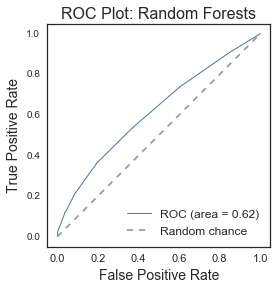


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY


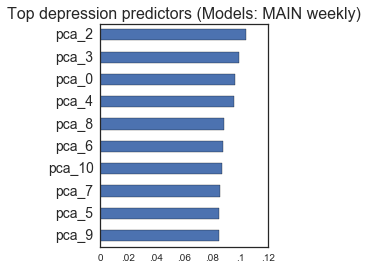

actualpos: 1099
total y_test: 4516
prevalence: 0.243356953056

Out of 100 random observations...

n1 25.0
n0 75.0
4.0 positive IDs
3.0 false alarms
21.0 false negatives
72.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: weekly

Optimization terminated successfully.
         Current function value: 0.534854
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                15053
Model:                          Logit   Df Residuals:                    15041
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Aug 2016   Pseudo R-squ.:                 0.02526
Time:                        09:47:57   Log-Likelihood:                -8051.2
converged:                       True   LL-Null:                       -8259.8
                                        LLR p-value:                 1.281e-82
 

In [33]:
#action_params['best_pca'] = 39

if run_separate_pca:
    master = data['master']
    report = 'MAIN'

    for gb_type in ['created_date','weekly']:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'test_size':.3,
                    'acc_avg':'binary',
                    'best_pca_num_comp':action_params['best_pca'],#(adds 1 to value); opt 69 tw-MAIN-created_date, but 2 works!
                    'show_pca_comp_plot':action_params['show_pca_comp_plot'],
                    'kernel':'rbf',
                    'tall_plot':action_params['tall_plot'],
                    'rf_params': {'class_wt':'balanced',
                                  'max_feat':'sqrt',
                                  'n_est':10,
                                  'min_ss':2,
                                  'min_sl':1,
                                  'max_depth':None,
                                  'imp_cutoff':.015,
                                  'imp_subset':10} # params optimized with 5-fold CV, see optimize_rf_hyperparams()
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        output, pca_df, best_f1, master_results = make_models(model_df, clf_types=clfs, 
                                                           excluded_set=excluded_set, 
                                                           use_pca=True)
        
        save_master_to_file(additional_data, posting_cutoff, run_separate_pca, action_params['best_pca']+1,
                            gb_type, report, condition, platform, pca_df)
        
        print
        print 'LOGISTIC REGRESSION'
        print logreg_wrapper(pca_df, gb_type, None, None, additional_data='pca')
